# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

В данном домашнем задании вам будет обучиться на данных с кэггла и заслать в [соревнование](https://www.kaggle.com/t/325e82797935464aa07c254b3cc3d8ad) предикт. Чтобы контест отображался, откройте и примите условия участия в контесте через ссылку-приглашение в телеграм-канале. По той же ссылке можете скачать данные.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву.

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 0.92 на публичном лидерборде. В противном случае мы будем вынуждены не засчитать задание :( 

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Для локального тестирования используйте предоставленное разбиение на трейн и тест.

Good luck & have fun! 💪

#### Использовать любые данные для обучения кроме предоставленных организаторами строго запрещено. В последней части можно использовать предобученные модели из библиотеки `transformers`.

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
PATH_TO_TRAIN_DATA = 'drive/MyDrive/train.csv'
PATH_TO_TEST_DATA = 'drive/MyDrive/test.csv'

In [122]:
train = pd.read_csv(PATH_TO_TRAIN_DATA)
train.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [6]:
nltk.download('punkt')
nltk.download("stopwords")

lemmatizer = nltk.stem.WordNetLemmatizer()
dict_text = set()

def process_text(text, label):
    global dict_text
    text = text.replace('No ', 'No')
    text = text.replace('no ', 'no')
    text = text.replace('Not ', 'not')
    text = text.replace('not ', 'not')
    words = [lemmatizer.lemmatize(word) + label for word in 
             word_tokenize(text.lower()) if word not in string.punctuation]
    # dict_text = dict_text.union(set(words))  # узнать длину словаря
    return words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [123]:
# т.к. далее склеиваем negative и positive, навесим метки на каждое слово в neg/pos, было оно neg/pos
train['negative'] = train['negative'].apply(process_text, label='neg')
train['positive'] = train['positive'].apply(process_text, label='pos')

train['full'] = train['negative'] + train['positive']
train = train[train['full'].map(len) != 0]

In [ ]:
len(dict_text)  # длина словаря

34728

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [8]:
tfidf = TfidfVectorizer(preprocessor=' '.join, max_features = 5000) # считать частоту слов не стала, попробовала методом тыка подобрать удачное число

X = train['full']
y = train['score']
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train_vectorized = tfidf.fit_transform(X_train)

In [ ]:
model = LinearRegression().fit(X_train_vectorized, y_train)
mean_absolute_error(y_test, model.predict(tfidf.transform(X_test)))

0.8327106658649905

Предскажите этой моделью тестовые данные из [соревнования](https://www.kaggle.com/t/325e82797935464aa07c254b3cc3d8ad) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

In [124]:
# позже поняла, что лучше было обучить модель на всем трейне, а потом сделать
# предсказание на тесте, но не хочется сейчас запускать все заново 

test = pd.read_csv(PATH_TO_TEST_DATA)

test['negative'] = test['negative'].apply(process_text, label='neg')
test['positive'] = test['positive'].apply(process_text, label='pos')
test['full'] = test['negative'] + test['positive']
test = test[test['full'].map(len) != 0]

In [ ]:
result = model.predict(tfidf.transform(test['full']))

In [ ]:
result = pd.DataFrame(data=result, columns=['score']).set_index(test.review_id)

In [ ]:
result.to_csv('result.csv')
!cp result.csv "drive/My Drive/"

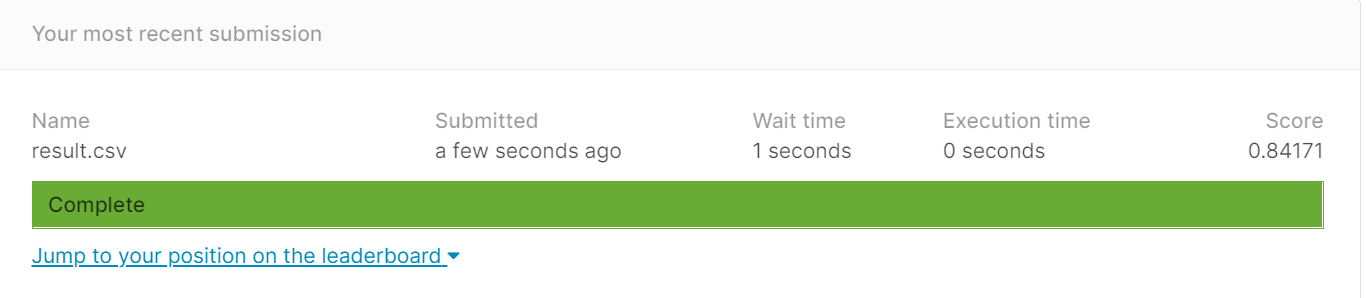

### Часть 2. 2 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [11]:
def vectorize(emb_model, words):
  # получаем вектор слова для тех слов, которые есть в словаре (у нас это все, т.к. так задали словарь)
  vectors = [emb_model.wv.get_vector(word) for word in words if word in emb_model.wv.vocab]

  return np.mean(vectors, axis=0) # усредняем

In [ ]:
def mae_without_idf(emb_model):
  train['vector'] = train['full'].apply(lambda words: vectorize(emb_model, words))
  X = train['vector'].values
  y = train['score'].values
  X_train, X_test, y_train, y_test = train_test_split(X, y)

  X_train = list(X_train)
  X_test = list(X_test)

  model = LinearRegression().fit(X_train, y_train)

  mae = mean_absolute_error(y_test, model.predict(X_test))
  print('MAE без весов:', mae)
  return mae

In [ ]:
embedding_size = 120
w2vmodel = gensim.models.Word2Vec(train['full'], size=embedding_size, min_count=1)
mae_without_idf(w2vmodel)

MAE without idf: 0.9176740047888657


0.9176740047888657

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [ ]:
def calc_idf(texts):
  cv = CountVectorizer() 
  word_count_vector = cv.fit_transform(texts)

  tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True) 
  tfidf_transformer.fit(word_count_vector)

  words = cv.get_feature_names()  # т.к. в cv хранится токен -- число повторений
  idf = tfidf_transformer.idf_

  return dict(zip(words, idf))  # словарь с ключами из words и значениями из idf


concated = []  # тут все записи хранятся
for value in train['full']:
  concated += value
idf_vocab = calc_idf(concated)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def vectorize_with_idf(emb_model, words):
  # если слово в словаре модели и для него есть, то берем вектор слова и умножаем на его вес
  vectors = np.array(list(emb_model.wv.get_vector(word) * idf_vocab[word] for word in words 
                          if word in emb_model.wv.vocab and word in idf_vocab))
  if len(vectors) == 0:
    return np.array([[0] for _ in range(embedding_size)])
  return np.array(np.mean(vectors, axis=0))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

def mae_with_idf(emb_model):
  train['vector_idf'] = train['full'].apply(lambda words: vectorize_with_idf(emb_model, words))

  X = train['vector_idf']
  y = train['score']
  X_train, X_test, y_train, y_test = train_test_split(X, y)

  X_train = list(X_train)
  X_test = list(X_test)

  model = LinearRegression().fit(X_train, y_train)
  mae = mean_absolute_error(y_test, model.predict(X_test))

  print('MAE с весами:', mae)
  return mae

In [ ]:
mae_with_idf(w2vmodel)

MAE with idf: 
0.9137205887481714


0.9137205887481714

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 

In [ ]:
mae_result = []
mae_with_idf_result = []

for embedding_size in range(50, 401, 50):
  w2vmodel = gensim.models.Word2Vec(train['full'], size=embedding_size, min_count=1)
  print('embedding_size:', embedding_size)
  
  mae_result.append(mae_without_idf(w2vmodel))
  mae_with_idf_result.append(mae_with_idf(w2vmodel))

embedding_size: 50
MAE without idf: 0.9542869528005912
MAE with idf: 
0.9536072895247351
embedding_size: 100
MAE without idf: 0.9313761032725855
MAE with idf: 
0.9357031644241844
embedding_size: 150
MAE without idf: 0.9219704828213118
MAE with idf: 
0.9200947166171101
embedding_size: 200
MAE without idf: 0.904669855550707
MAE with idf: 
0.9074976551823151
embedding_size: 250
MAE without idf: 0.9039730164874928
MAE with idf: 
0.9015356057338454
embedding_size: 300
MAE without idf: 0.9014183705318183
MAE with idf: 
0.9012154606629517
embedding_size: 350
MAE without idf: 0.8922093691418251
MAE with idf: 
0.8941999058613009
embedding_size: 400
MAE without idf: 0.8886137559760202
MAE with idf: 
0.8910895277516422


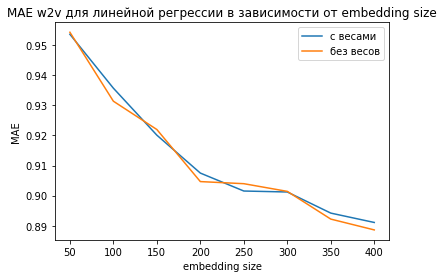

In [ ]:
sizes = list(range(50, 401, 50))

plt.title('MAE w2v для линейной регрессии в зависимости от embedding size')
plt.plot(sizes, mae_with_idf_result, label = 'с весами')
plt.plot(sizes, mae_result, label = 'без весов')
plt.xlabel('embedding size')
plt.ylabel('MAE')

plt.legend()
plt.show()

#### Сделайте выводы:

С увеличением embedding size в обоих случаях ошибка падает, но уменьшение при обучении с весами более плавное. В целом качество похожее у обеих семейств моделей, тяжело сказать, какую модель лучше использовать. Но когда я не делала такую хорошую предобработку, как в итоге сделала, кривая для модели с весами лежала полностью под кривой для модели без весов. Возможно, из-за того, что я сделала хорошую предобработку, в данном случае просто обе модели стали работать хорошо.

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.

In [ ]:
embedding_size = 300
fasttextmodel = gensim.models.FastText(train['full'], size=embedding_size, min_count=1)
print('--- Fasttext ---')
mae_without_idf(fasttextmodel)
mae_with_idf(fasttextmodel)

Для fasttext
MAE without idf: 0.9025510662340862
MAE with idf: 
0.9096485175172387


0.9096485175172387

#### Выводы:
Ошибка незначительно увеличилась (в третьем знаке после запятой). Но мы видели, как в нашем случае меняется расположение кривых ошибок с увеличением embedding size, поэтому построим еще и для других embedding_size (для наглядности построим график).

embedding_size: 50
MAE without idf: 0.9534428076074766
MAE with idf: 
0.9545082760303514
embedding_size: 100
MAE without idf: 0.9269172903261039
MAE with idf: 
0.9271380398291492
embedding_size: 150
MAE without idf: 0.9231190964042523
MAE with idf: 
0.915493151563526
embedding_size: 200
MAE without idf: 0.9010988997642486
MAE with idf: 
0.9081382388291137
embedding_size: 250
MAE without idf: 0.906516383324553
MAE with idf: 
0.9081493382339665
embedding_size: 300
MAE without idf: 0.9036883816127181
MAE with idf: 
0.9103628244174566
embedding_size: 350
MAE without idf: 0.8969884611233753
MAE with idf: 
0.8992241021313521
embedding_size: 400
MAE without idf: 0.8976264364791205
MAE with idf: 
0.8936077932771851


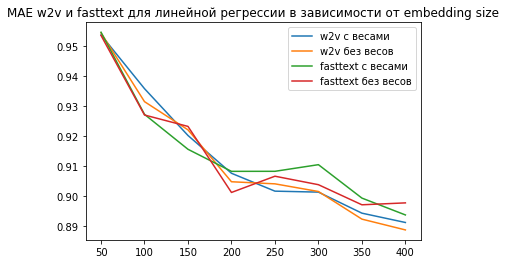

In [ ]:
mae_result_fasttext = []
mae_with_idf_result_fasttext = []

for embedding_size in range(50, 401, 50):
  fasttextmodel = gensim.models.FastText(train['full'], size=embedding_size, min_count=1)
  print('embedding_size:', embedding_size)

  mae_result_fasttext.append(mae_without_idf(fasttextmodel))
  mae_with_idf_result_fasttext.append(mae_with_idf(fasttextmodel))

sizes = list(range(50, 401, 50))
plt.title('MAE w2v и fasttext для линейной регрессии в зависимости от embedding size')

plt.plot(sizes, mae_with_idf_result, label='w2v с весами')
plt.plot(sizes, mae_result, label = 'w2v без весов')
plt.plot(sizes, mae_with_idf_result_fasttext, label='fasttext с весами')
plt.plot(sizes, mae_result_fasttext, label = 'fasttext без весов')
plt.legend()
plt.show()

fasttext с увеличением embedding size как-то непредсказуемо меняется, в отличие от w2v (хотя кажется, что fasttext с весами идет на убывание MAE, а про fasttext с весами неясно. Т.е. все же с весами лучше, чем без весов). Лучшее качество --- при embedding_size >= 400 для w2v или fasttext с весами. Попробуем сделать следующее задание для embedding size = 400 --- w2v без весов.

Предскажите вашей лучшей моделью из этого задания тестовые данные из [соревнования](https://www.kaggle.com/t/325e82797935464aa07c254b3cc3d8ad) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

In [ ]:
w2vmodel = gensim.models.Word2Vec(train['full'], size=400, min_count=1)
train['vector'] = train['full'].apply(lambda words: vectorize(w2vmodel, words))
X = list(train['vector'].values)
y = list(train['score'].values)

In [ ]:
model = LinearRegression().fit(X, y)
test['vector'] = test['full'].apply(lambda words: vectorize(w2vmodel, words))

X = list(test['vector'].values)
result = model.predict(X)

In [ ]:
result = pd.DataFrame(data=result, columns=['score']).set_index(test.review_id)

In [ ]:
result.to_csv('task2.csv')
!cp task2.csv "drive/My Drive/"

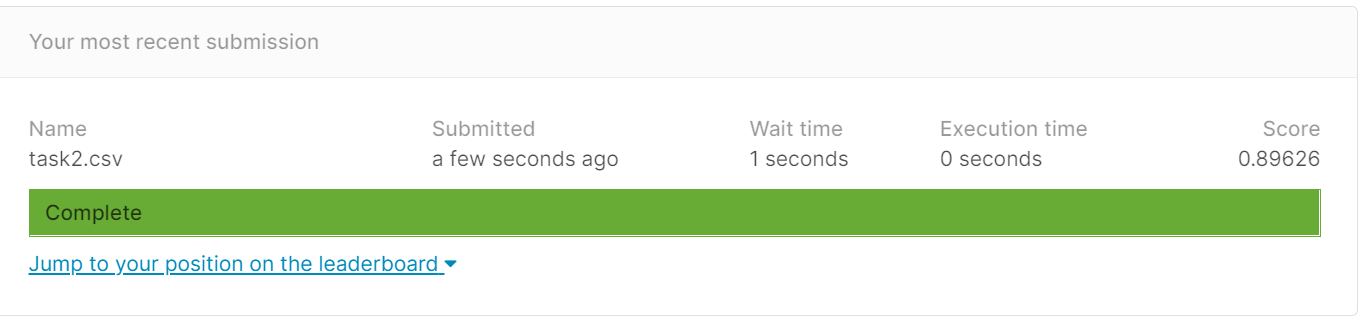

### Часть 3. 4 балла

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [125]:
import torch
from torch import nn
from torch.nn import functional as F

In [126]:
# формируем словарь

WORDS = set()
for sent in list(train['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(train['negative']):
    for w in sent:
        WORDS.add(w)

In [127]:
# по номеру слова получаем слово и наоборот

int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [128]:
# максимальная длина отзыва

MAX_LEN = max(max(train['positive'].apply(len)), max(train['negative'].apply(len)))

In [ ]:
MAX_LEN

392

In [129]:
# класс для датасетов

class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df['full']
        self.scores = df['score']
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        review = self.texts.iloc[idx]
        review_tensor = torch.as_tensor([word2int[w] for w in review][:MAX_LEN])
        review_padded = F.pad(review_tensor, (0, MAX_LEN - len(review_tensor)), 'constant', 0)

        return review_padded, torch.tensor(self.scores.iloc[idx], dtype=torch.float32)

In [ ]:
# формируем батчи размера 4

BATCH_SIZE = 4

df_train, df_test = train_test_split(train)
train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [131]:
# нулевой паддинг, чтобы все элементы DataLoader были одинаковой размерности

from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
                           batch_first=True)

In [89]:
assert len(train_dataset[0]) == 2
assert len(train_dataset[0][0]) == MAX_LEN

In [132]:
for text, score in train_dataloader:
  print(text, score)
  break

tensor([[ 5140, 30435,    56,  ...,     0,     0,     0],
        [ 9634, 45287, 34302,  ...,     0,     0,     0],
        [ 9911, 33224, 29211,  ...,     0,     0,     0],
        [32376,  8453,  1055,  ...,     0,     0,     0]]) tensor([6.3000, 4.2000, 8.3000, 9.6000])


In [180]:
# класс для модели

class ReviewModel(nn.Module):
  def __init__(self, input_size, embedding_dim, hidden_dim, n_lstm_layers, vocab_size):
        super(ReviewModel, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=n_lstm_layers,
                            batch_first=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(self.hidden_dim * input_size, 300)
        self.linear2 = nn.Linear(300, 1)

  def forward(self, sentence):
      embeds = self.word_embeddings(sentence)
      lstm_out, _ = self.lstm(embeds)
      relu_out = self.relu(lstm_out.reshape(lstm_out.shape[0], -1))
      lin1_out = self.linear1(relu_out)
      score = self.linear2(self.relu(lin1_out))
      return score.view(-1)

In [181]:
# одна эпоха обучения + предсказание

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    num_batches = 0
    total_predictions = np.array([])
    total_scores = np.array([])
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0, leave=True)
    for reviews, scores in train_dataloader:
        reviews = reviews.to(device)
        scores = scores.to(device)
        predicted = model(reviews)
        loss = criterion(predicted, scores)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.update(1)

        total_predictions = np.append(total_predictions, predicted.cpu().detach().numpy())
        total_scores = np.append(total_scores, scores.cpu().detach().numpy())
        num_batches += 1

    metrics = {'mae': mean_absolute_error(total_predictions, total_scores)}
    pbar.set_description(f"Train mae: {round(metrics['mae'], 4)}")
    return metrics

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.to(device).eval()
    num_batches = 0
    total_predictions = np.array([])
    total_scores = np.array([])
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), position=0, leave=True)
    for i, (reviews, scores) in pbar:
        reviews = reviews.to(device)
        scores = scores.to(device)
        predicted = model(reviews)
        total_predictions = np.append(total_predictions, predicted.cpu().detach().numpy())
        total_scores = np.append(total_scores, scores.cpu().detach().numpy())
        num_batches += 1
        pbar.update(1)
    metrics = {'mae': mean_absolute_error(total_predictions, total_scores)}
    return metrics, total_predictions, total_scores

In [182]:
# обучение

NUM_EPOCHS = 1

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=NUM_EPOCHS, scheduler=None):
  model = model.to(device)
  for epoch in range(n_epochs):
      print(f"Train Epoch: {epoch}")
      train_metrics = train_one_epoch(
          model=model,
          train_dataloader=train_dataloader,
          criterion=criterion,
          optimizer=optimizer,
          device=device
      )        
      # Eval step
      print(f"Validation Epoch: {epoch}")
      with torch.no_grad():
          validation_metrics, total_predictions, total_scores = predict(
              model=model,
              val_dataloader=val_dataloader,
              criterion=criterion,
              device=device
          )
      print(f"Validation mae: {round(validation_metrics['mae'], 4)}")
      scheduler.step(validation_metrics['mae'])

In [153]:
from tqdm.notebook import tqdm

model = ReviewModel(input_size=MAX_LEN, embedding_dim=300, hidden_dim=64, n_lstm_layers=2, vocab_size=len(word2int))

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
criterion = torch.nn.L1Loss() 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
n_epochs = 3
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

train(model, train_dataloader, test_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train Epoch: 0


  0%|          | 0/18749 [00:00<?, ?it/s]

Validation Epoch: 0
Validation mae: 0.81
Train Epoch: 1


  0%|          | 0/18749 [00:00<?, ?it/s]

Validation Epoch: 1
Validation mae: 0.7873
Train Epoch: 2


  0%|          | 0/18749 [00:00<?, ?it/s]

Validation Epoch: 2
Validation mae: 0.767


Получила!

### Контест (до 3 баллов)

По итогам всех ваших экспериментов выберите модель, которую считаете лучшей. Сделайте сабмит в контест. В зависимости от вашего скора на публичном лидерборде, мы начислим вам баллы:

 - <0.77 - 3 балла
 - [0.77; 0.78) - 2 балла
 - [0.78; 0.8) - 1 балл

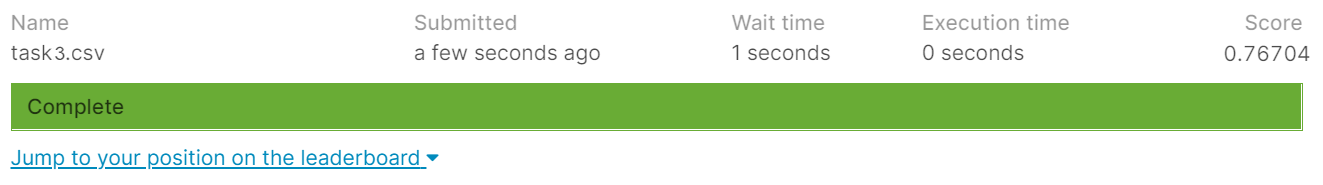

Ура! Было еще переобучение сначала, но покрутила гиперпараметры --- стало нормально.